# Setup & Utilities

In [ ]:
import os, pickle, json
from pathlib import Path
from typing import Tuple, Dict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

import h5py
import numpy as np
import torch
from torch_geometric_temporal.signal import StaticGraphTemporalSignal

RESULTS_DIR = Path("results")
(RESULTS_DIR / "plots").mkdir(parents=True, exist_ok=True)
(RESULTS_DIR / "baselines").mkdir(parents=True, exist_ok=True)


def mae(y_true: np.ndarray, y_pred: np.ndarray, axis=None) -> float:
    return np.nanmean(np.abs(y_true - y_pred), axis=axis)

def rmse(y_true: np.ndarray, y_pred: np.ndarray, axis=None) -> float:
    return np.sqrt(np.nanmean((y_true - y_pred)**2, axis=axis))

def train_val_test_split(T: int, train_ratio=0.7, val_ratio=0.1):
    """Return indices (slice objects) for temporal splits."""
    t_train = int(T*train_ratio)
    t_val = t_train + int(T*val_ratio)
    return slice(0, t_train), slice(t_train, t_val), slice(t_val, T)

/Volumes/Crucial1TB/MyProjects/metr_la/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# Data Loading

## Load the sensor reading data

In [2]:
def load_metr_la_h5(path, key="/df/block0_values"):
    """Load METR-LA traffic speed matrix from HDF5 (pandas store format)."""
    with h5py.File(path, "r") as f:
        data = f[key][:]   # shape: (time_steps, num_sensors)
    # Replace NaN with 0 for safety
    data = np.nan_to_num(data)
    return data


In [6]:
path = "/Volumes/Crucial1TB/MyProjects/metr_la/data/metr-la.h5"
data = load_metr_la_h5(path)

print("Shape:", data.shape)   # (34272, 207)
print("Time steps:", data.shape[0])
print("Sensors:", data.shape[1])
n_timesteps, n_sensors = data.shape

Shape: (34272, 207)
Time steps: 34272
Sensors: 207


## Load the sensor graph data

In [24]:
# Load adj_mx.pkl
with open("/Volumes/Crucial1TB/MyProjects/metr_la/data/adj_mx.pkl", "rb") as f:
    sensor_ids, sensor_id_to_ind, adj_mx = pickle.load(f, encoding="latin1")

adj_mx = adj_mx.astype(np.float32)  # just in case

print("Adjacency shape:", adj_mx.shape)
print("Number of sensors:", len(sensor_ids))

Adjacency shape: (207, 207)
Number of sensors: 207


# EDA


## Sensor reading over time

In [55]:
# sensor_ids is a list/array of sensor IDs in column order
sensor_id_to_ind = {int(sid): i for i, sid in enumerate(sensor_ids)}

Most congested sensor: 771667
Average speed: 28.31 mph


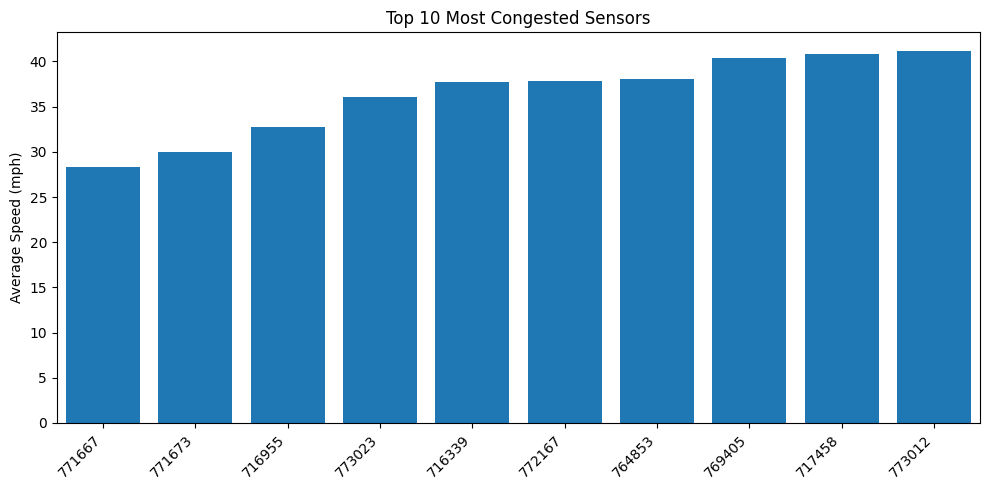

In [51]:
# Compute average speed per sensor
avg_speeds = np.nanmean(data, axis=0)  # shape: (num_sensors,)

# Find most congested sensor (lowest avg speed)
most_congested_idx = np.argmin(avg_speeds)
most_congested_sensor = sensor_ids[most_congested_idx]
most_congested_speed = avg_speeds[most_congested_idx]

print(f"Most congested sensor: {most_congested_sensor}")
print(f"Average speed: {most_congested_speed:.2f} mph")

# Visualize top-k congested sensors
k = 10
top_k_idx      = np.argsort(avg_speeds)[:k]
top_k_sensors  = [str(int(sensor_ids[i])) for i in top_k_idx]  # force strings
top_k_speeds   = avg_speeds[top_k_idx]

x = np.arange(k)  # positions 0..k-1
plt.figure(figsize=(10,5))
plt.bar(x, top_k_speeds)
plt.xticks(x, top_k_sensors, rotation=45, ha="right")
plt.ylabel("Average Speed (mph)")
plt.title(f"Top {k} Most Congested Sensors")
plt.gca().margins(x=0.01)        # reduce side padding
plt.tight_layout()
plt.show()

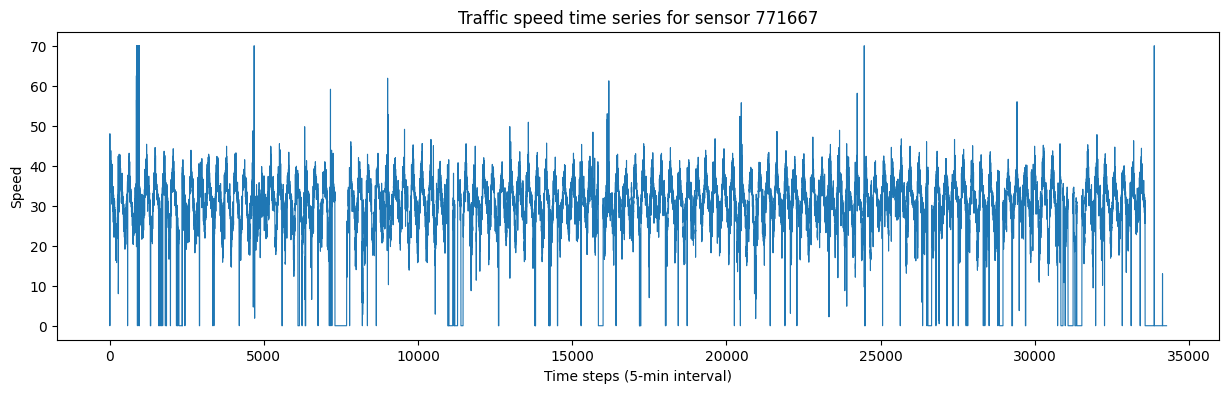

In [64]:
# Plot time series of a single sensor
sensor_id = 771667  # pick the first sensor
plt.figure(figsize=(15,4))
plt.plot(data[:, sensor_id_to_ind[sensor_id]], lw=0.8)
plt.title(f"Traffic speed time series for sensor {sensor_id}")
plt.xlabel("Time steps (5-min interval)")
plt.ylabel("Speed")
plt.show()

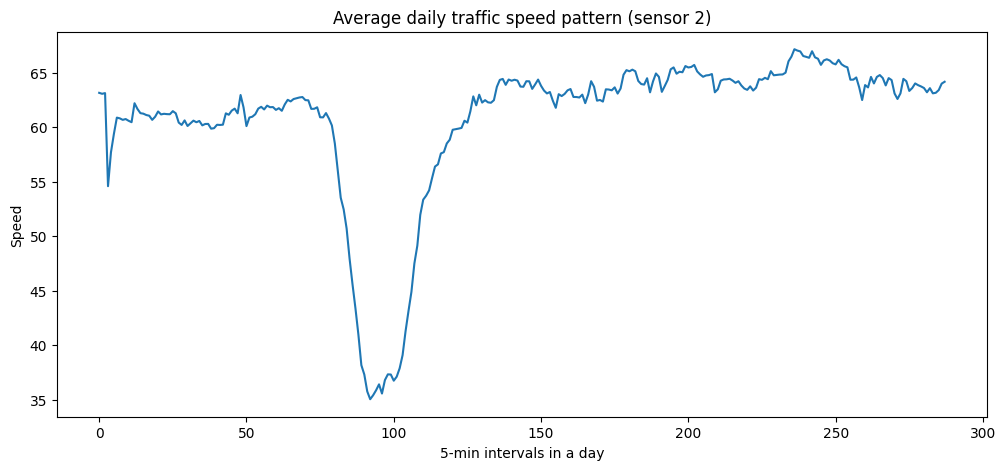

In [14]:
# Daily pattern (average across days)
intervals_per_day = 288
days = n_timesteps // intervals_per_day
reshaped = data[:days*intervals_per_day, sensor_id].reshape(days, intervals_per_day)

plt.figure(figsize=(12,5))
plt.plot(reshaped.mean(axis=0))
plt.title(f"Average daily traffic speed pattern (sensor {sensor_id})")
plt.xlabel("5-min intervals in a day")
plt.ylabel("Speed")
plt.show()

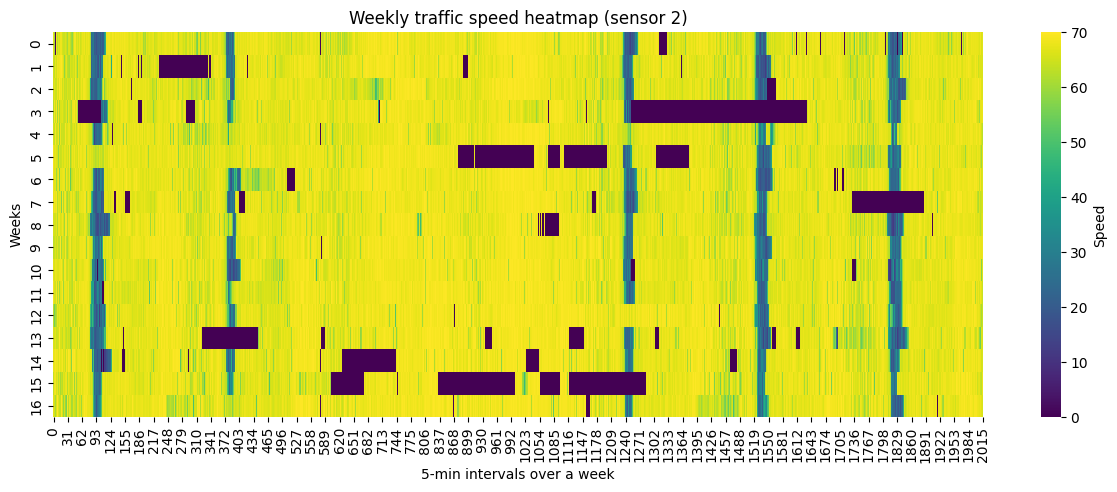

In [19]:
# Weekly pattern
intervals_per_week = intervals_per_day * 7
weeks = n_timesteps // intervals_per_week
reshaped_week = data[:weeks*intervals_per_week, sensor_id].reshape(weeks, intervals_per_week)

plt.figure(figsize=(15,5))
sns.heatmap(reshaped_week, cmap="viridis", cbar_kws={"label": "Speed"})
plt.title(f"Weekly traffic speed heatmap (sensor {sensor_id})")
plt.xlabel("5-min intervals over a week")
plt.ylabel("Weeks")
plt.show()

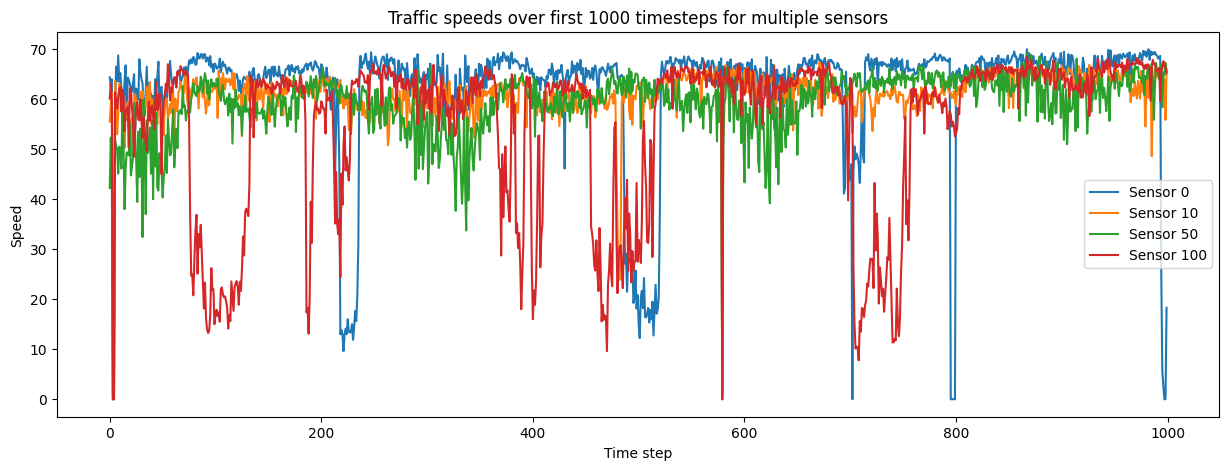

In [20]:
plt.figure(figsize=(15,5))
for sid in [0, 10, 50, 100]:
    plt.plot(data[:1000, sid], label=f"Sensor {sid}")
plt.legend()
plt.title("Traffic speeds over first 1000 timesteps for multiple sensors")
plt.xlabel("Time step")
plt.ylabel("Speed")
plt.show()

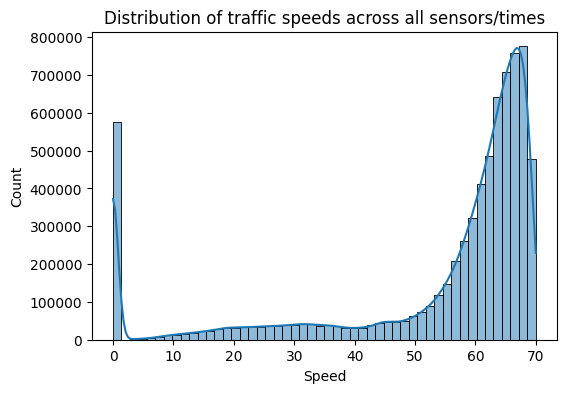

In [22]:
# Distribution of traffic speed
plt.figure(figsize=(6,4))
sns.histplot(data.flatten(), bins=50, kde=True)
plt.title("Distribution of traffic speeds across all sensors/times")
plt.xlabel("Speed")
plt.ylabel("Count")
plt.show()

## Graph data

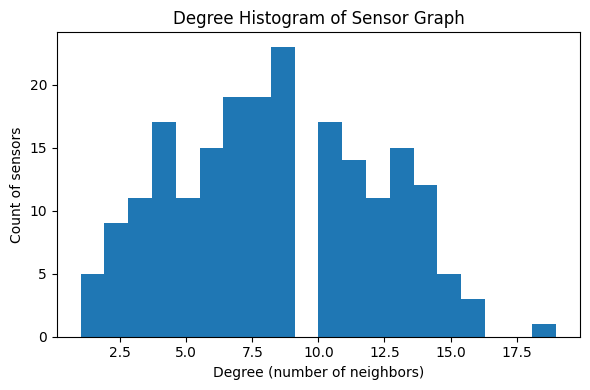

In [26]:
# Degree
degrees = (adj_mx > 0).sum(axis=1)

plt.figure(figsize=(6,4))
plt.hist(degrees, bins=20)
plt.title("Degree Histogram of Sensor Graph")
plt.xlabel("Degree (number of neighbors)")
plt.ylabel("Count of sensors")
plt.tight_layout()
plt.show()

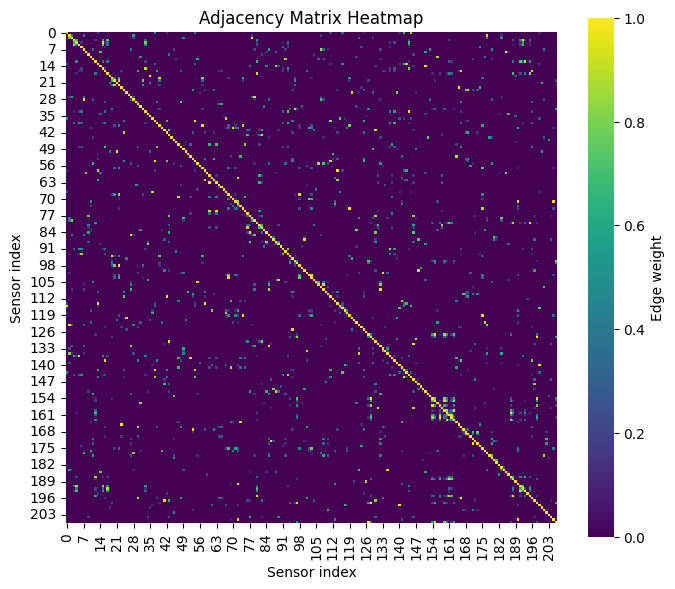

In [27]:
# Visualize Adjacency Heatmap

plt.figure(figsize=(7,6))
sns.heatmap(adj_mx, cmap="viridis", square=True, cbar_kws={"label": "Edge weight"})
plt.title("Adjacency Matrix Heatmap")
plt.xlabel("Sensor index")
plt.ylabel("Sensor index")
plt.tight_layout()
plt.show()

In [ ]:
# Overlay the sensors onto the actual earth map
import os
import pandas as pd
import folium

DATA_DIR = "../data"
LOC_CSV  = os.path.join(DATA_DIR, "graph_sensor_locations.csv")
OUT_HTML = "../results/metr_la_sensors.html"

def load_locations(csv_path: str) -> pd.DataFrame:
    df = pd.read_csv(csv_path)
    # normalize expected columns
    lc = {c.lower(): c for c in df.columns}
    idc  = lc.get("sensor_id") or lc.get("id") or lc.get("sensorid")
    latc = lc.get("lat") or lc.get("latitude")
    lonc = lc.get("lon") or lc.get("lng") or lc.get("longitude") or lc.get("long")
    altc = lc.get("alt") or lc.get("altitude")  # optional
    if not all([idc, latc, lonc]):
        raise ValueError(f"Need sensor_id/lat/lon columns; found {list(df.columns)}")
    keep = ["sensor_id", "lat", "lon"] + ([altc] if altc else [])
    df = df.rename(columns={idc:"sensor_id", latc:"lat", lonc:"lon"})
    if altc: df = df.rename(columns={altc:"alt"})
    return df[keep]

def make_map():
    os.makedirs(os.path.dirname(OUT_HTML), exist_ok=True)
    locs = load_locations(LOC_CSV)

    # center of map = mean of all sensor positions
    center = [locs["lat"].mean(), locs["lon"].mean()]
    m = folium.Map(location=center, zoom_start=11, tiles="cartodbpositron")

    for _, r in locs.iterrows():
        popup = f"Sensor {r['sensor_id']}"
        if "alt" in r:
            popup += f"<br>Altitude: {r['alt']}"
        folium.CircleMarker(
            location=[r["lat"], r["lon"]],
            radius=4,
            color="#2a7fff",
            fill=True,
            fill_opacity=0.9,
            popup=popup
        ).add_to(m)

    m.save(OUT_HTML)
    print(f"Saved map → {OUT_HTML}")

make_map()

Saved map → results/metr_la_sensors.html
